In [188]:
from requests import get
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import array
from numpy import argmax
#import keras
#from keras.utils import to_categorical

Following code gets data for a selected number of movies released between 1934-01-01 and 2017-12-31, ordered by popularity (ordered by IMDB)

In [2]:
actorAwards = ['Actor', 'Actor in a Supporting Role', 'Actress', 'Actress in a Supporting Role', 'Actor in a Leading Role', 
               'Actress in a Leading Role']
#Awards that can be received directly by an actor/actress

directorAwards = ['Directing'] #For this dataset that name of the director is in the 'Film' category
#Awards that can be received directly by a director

movieAwards = ['Best Motion Picture', 'Outstanding Motion Picture', 'Documentary', 'Documentary (Feature)', 
               'Documentary (Short Subject)', 'Short Subject (Cartoon)', 'Short Subject (One Reel)',
               'Short Film (Animated)', 'Short Film (Live Action)', 'Best Picture', 'Animated Feature Film'] #Movie name is in the 'name' category
#Awards that directors and actors can directly influence

#Awards like writing, screenplay, production, etc are saved under other awards as the actor and director do not
#influence them as directly (or at all) as the ones above

OscarRead = pd.read_csv('OscarDatabase.csv') #read the database
yearCSV = OscarRead["Year"] #The year the movie was released
awardCSV = OscarRead["Award"] #The name of the award received/nominated for
winnerCSV = OscarRead["Winner"] #If the entry won or not

resultsCSV = winnerCSV.copy() #Create a copy to edit
resultsCSV[resultsCSV != 1] = 0 #Original CSV has a '1' for winner, and NaN for a nomination - convert NaN to '0'

nameCSV = OscarRead["Name"] 
filmCSV = OscarRead["Film"]

win = 1
nomination = 0

def getDict(awards, result = win, name = nameCSV, film = filmCSV, starAwards = True, otherAwards = False):
    """awards = list containing awards interested in.
       nameOrFilm = column that contains the actor/director name (different for different awards)
       Returns a new nested dictionary where the outside key is 
       a year, and the inside key is the name of actor/film/director
       who received a nomination or won an award in the list
       for the years 1935-2016"""
    
    Dict = {}
    for i in range(len(yearCSV)):
        if otherAwards == False and awardCSV[i] not in awards or resultsCSV[i] != result:
            continue
        elif otherAwards == True and awardCSV[i] in awards or resultsCSV[i] != result:
            continue
        if starAwards == False:
            try:
                try:
                    Dict[yearCSV[i] + 1][name[i]] += 1 #If the movie wins multiple awards in a year
                except:
                    Dict[yearCSV[i] + 1][name[i]] = 1 #Set the value for movie to one if the year is already in the dictionary
            except:
                Dict[yearCSV[i] + 1] = {} #if year is not in dictionary yet then create it
                Dict[yearCSV[i] + 1][name[i]] = 1 #set the value to one
                #Above code uses year + 1 for the key as the original database has the release year of the movie stored, 
                #not the year of the oscars
        else:
            try:
                try:
                    Dict[yearCSV[i] + 1][name[i]][1] += 1
                except:
                    Dict[yearCSV[i] + 1][name[i]] = film[i], 1
            except:
                Dict[yearCSV[i] + 1] = {}
                Dict[yearCSV[i] + 1][name[i]] = film[i], 1            
    return Dict
#Following dictionaries have data for 1935-2016
#If a movie/actor/director wins an award, it is only saved as a winner and will not have an entry for the nomination
#it received for that award
OscarActorWinners = getDict(actorAwards)
OscarActorNoms = getDict(actorAwards, nomination)
OscarDirWinners = getDict(directorAwards, name = filmCSV, film = nameCSV)
OscarDirNoms = getDict(directorAwards, nomination, name = filmCSV, film = nameCSV)
movieWinners = getDict(movieAwards, starAwards = False)
movieNoms = getDict(movieAwards, nomination, starAwards = False)
otherAwardWinners = getDict(actorAwards + movieAwards + directorAwards, starAwards = False, otherAwards = True)
otherAwardNoms = getDict(actorAwards + movieAwards + directorAwards, nomination, starAwards = False, otherAwards = True)

print("1950 oscar winners (acting) are:", OscarActorWinners[1951])
print("1950 oscar nominees (acting) are:", OscarActorNoms[1950])
print("1950 oscar winners (directing) are:", OscarDirWinners[1950])
print("1950 oscar nominees (directing) are:", OscarDirNoms[1950])
print("1950 oscar winners (movie) are:", movieWinners[1950])
print("1950 oscar nominees (movie) are:", movieNoms[1950])
print("1950 oscar winners (other) are:", otherAwardWinners[1950])
print("1950 oscar nominees (other) are:", otherAwardNoms[1950])

otherAwardWinners[2018]

1950 oscar winners (acting) are: {'José Ferrer': ('Cyrano de Bergerac', 1), 'George Sanders': ('All about Eve', 1), 'Judy Holliday': ('Born Yesterday', 1), 'Josephine Hull': ('Harvey', 1)}
1950 oscar nominees (acting) are: {'Kirk Douglas': ('Champion', 1), 'Gregory Peck': ("Twelve O'Clock High", 1), 'Richard Todd': ('The Hasty Heart', 1), 'John Wayne': ('Sands of Iwo Jima', 1), 'John Ireland': ("All the King's Men", 1), 'Arthur Kennedy': ('Champion', 1), 'Ralph Richardson': ('The Heiress', 1), 'James Whitmore': ('Battleground', 1), 'Jeanne Crain': ('Pinky', 1), 'Susan Hayward': ('My Foolish Heart', 1), 'Deborah Kerr': ('Edward, My Son', 1), 'Loretta Young': ('Come to the Stable', 1), 'Ethel Barrymore': ('Pinky', 1), 'Celeste Holm': ('Come to the Stable', 1), 'Elsa Lanchester': ('Come to the Stable', 1), 'Ethel Waters': ('Pinky', 1)}
1950 oscar winners (directing) are: {'Joseph L. Mankiewicz': ('A Letter to Three Wives ', 1)}
1950 oscar nominees (directing) are: {'Robert Rossen': ("All 

{'Coco': 1,
 'The Shape of Water': 2,
 'Blade Runner 2049': 2,
 'Get Out': 1,
 'Call Me by Your Name': 1,
 'The Silent Child': 1,
 'Dunkirk': 3,
 'Dear Basketball': 1,
 'A Fantastic Woman': 1,
 'Phantom Thread': 1,
 'Darkest Hour': 1}

In [3]:
OscarActorWinners[2018]['Gary Oldman'][0] #Gary won an oscar for his role in Darkest Hour

'Darkest Hour'

In [4]:
OscarActorWinnersDupe = getDict(actorAwards, starAwards = False)
OscarActorNomsDupe = getDict(actorAwards, nomination, starAwards = False)
OscarDirWinnersDupe = getDict(directorAwards, name = filmCSV, film = nameCSV, starAwards = False)
OscarDirNomsDupe = getDict(directorAwards, nomination, name = filmCSV, film = nameCSV, starAwards = False)
#These are the same as the dictionaries above except that for the starAwards = False tag. Using this simply returns
#a dictionary of the form Dict[year][actor] = oscars won in year, instead of Dict[year][actor] = movie, num oscars
#Simply makes it easier to deal with just the numbers


startYear = 1934 + 1
endYear = 2018
def getRunningTotal(Dict):
    """Returns a dictionary that contains the amount
    of awards a actor/director has received at a given time"""
    totalDict = {}
    totalDict[startYear] = Dict[startYear]
            
    for year in range(startYear + 1, endYear + 1):
        totalDict[year] = {}
        totalDict[year].update(totalDict[year - 1]) #update dictionary with previous year to keep a running total each year
    
        for key, value in Dict[year].items():
            try:
                totalDict[year][key] += 1 #if the actor is already present increment by 1
            except:
                totalDict[year][key] = 1 #set it to 1 if not already present
    return totalDict

OscarActorWinnersTot = getRunningTotal(OscarActorWinnersDupe)
OscarActorNomsTot = getRunningTotal(OscarActorNomsDupe)
OscarDirWinnersTot = getRunningTotal(OscarDirWinnersDupe)
OscarDirNomsTot = getRunningTotal(OscarDirNomsDupe)

print(OscarActorWinnersTot[1953]['Anthony Quinn'])
print(OscarActorWinnersTot[1957]['Anthony Quinn']) #Anthony won an Oscar in 1953 and 1957
OscarActorWinnersTot[2018]

1
2


{'Clark Gable': 1,
 'Claudette Colbert': 1,
 'Victor McLaglen': 1,
 'Bette Davis': 2,
 'Paul Muni': 1,
 'Walter Brennan': 3,
 'Luise Rainer': 2,
 'Gale Sondergaard': 1,
 'Spencer Tracy': 2,
 'Joseph Schildkraut': 1,
 'Alice Brady': 1,
 'Fay Bainter': 1,
 'Robert Donat': 1,
 'Thomas Mitchell': 1,
 'Vivien Leigh': 2,
 'Hattie McDaniel': 1,
 'James Stewart': 1,
 'Ginger Rogers': 1,
 'Jane Darwell': 1,
 'Gary Cooper': 2,
 'Donald Crisp': 1,
 'Joan Fontaine': 1,
 'Mary Astor': 1,
 'James Cagney': 1,
 'Van Heflin': 1,
 'Greer Garson': 1,
 'Teresa Wright': 1,
 'Paul Lukas': 1,
 'Charles Coburn': 1,
 'Jennifer Jones': 1,
 'Katina Paxinou': 1,
 'Bing Crosby': 1,
 'Barry Fitzgerald': 1,
 'Ingrid Bergman': 3,
 'Ethel Barrymore': 1,
 'Ray Milland': 1,
 'James Dunn': 1,
 'Joan Crawford': 1,
 'Anne Revere': 1,
 'Fredric March': 1,
 'Harold Russell': 1,
 'Olivia de Havilland': 2,
 'Anne Baxter': 1,
 'Ronald Colman': 1,
 'Edmund Gwenn': 1,
 'Loretta Young': 1,
 'Celeste Holm': 1,
 'Laurence Olivier': 

In [5]:
for key, value in OscarDirWinnersTot[2018].items(): #Directors that won multiple awards (just for fun lol)
    if value >= 2:
        print(key)
        print(value)
        
for key, value in OscarActorWinnersTot[2018].items(): #Actors that won multiple awards (just for fun lol)
    if value >= 3:
        print(key)
        print(value)

Frank Capra
3
John Ford
4
Leo McCarey
2
William Wyler
3
Billy Wilder
2
Elia Kazan
2
Joseph L. Mankiewicz
2
George Stevens
2
Fred Zinnemann
2
David Lean
2
Milos Forman
2
Oliver Stone
2
Clint Eastwood
2
Steven Spielberg
2
Ang Lee
2
Alejandro G. Iñárritu
2
Walter Brennan
3
Ingrid Bergman
3
Katharine Hepburn
3
Jack Nicholson
3
Meryl Streep
3


In [71]:
urlArray = []

numMovies = 1000 #numMovies must be less than 300,908, numMovies % 50 must be 0

for i in range(1, numMovies - 48, 50): #create an array of urls to iterate through
    urlArray.append('https://www.imdb.com/search/title?title_type=feature&release_date=1950-01-01,2017-12-31&start='
                    + str(i) + '&ref_=adv_nxt')

In [7]:
def cleanData(year_, genre, runtime, box_office, votes):
    year1 = ''.join(c for c in year_ if c.isdigit()) #remove non-numeric characters from year
    
    genre1 = ''.join(c for c in genre if (c != '\n')) #original data has '\n' scattered around... remove those
    
    runtime1 = ''.join(c for c in runtime if c.isdigit()) #remove non-numeric characters from runtime
    
    box = ''.join(c for c in box_office if (c.isdigit() or c == '.')) #remove non-numeric characters, but keep the decimal
    box = round(float(box) * (10**6)) #original is in millions
    
    votes1 = ''.join(c for c in votes if c.isdigit()) #remove non-numeric characters from year
    
    
    return int(year1), genre1, int(runtime1), box, int(votes1)

In [8]:
def normalize(runtime, gross):
    nor_runtime = np.divide(runtime,max(runtime))
    nor_gross = np.divide(gross,max(gross))
    return nor_runtime, nor_gross

In [9]:
CPIdict = {}
CPIread = pd.read_csv('CPI.csv') #CPI.csv contains the multiplication factor to get from a given year to 2019 to adjust
                                 #for inflation
for i in range(len(CPIread["Growth"] + 1)):
     CPIdict[CPIread["Year"][i]] = CPIread["To 2019"][i]
print("Movies released in 1990 have a multiplier of", CPIdict[1990], "to their gross to adjust for inflation")

Movies released in 1990 have a multiplier of 1.9345070969999998 to their gross to adjust for inflation


In [10]:
def inflationAdjust(year, box_office):
    return int(round(box_office * CPIdict[year])) #multiplies the gross value by the multiplication factor for the year
                                                  #it was released

In [11]:
def getOscarNum(actor1, actor2, actor3, actor4, actor5, movieName, releaseYear):
    stars = []
    stars.extend([actor1, actor2, actor3, actor4, actor5])
    prevStarWins = prevStarNoms = starWins = starNoms = movieWins = movieNoms = otherWins = otherNoms = 0
    oscarYear = releaseYear + 1
    for star in stars:
        if star != '': #Checks how many oscar nominations and wins the directors and actors have prior to this movie
            prevStarWins += checkDict(star, OscarDirWinnersTot, releaseYear) #
            prevStarWins += checkDict(star, OscarActorWinnersTot, releaseYear)
            prevStarNoms += checkDict(star, OscarDirNomsTot, releaseYear)
            prevStarNoms += checkDict(star, OscarActorNomsTot, releaseYear)
            starWins += checkDict(star, OscarDirWinners, oscarYear, movie = movieName)
            starWins += checkDict(star, OscarActorWinners, oscarYear, movie = movieName)
            starNoms += checkDict(star, OscarDirNoms, oscarYear, movie = movieName)
            starNoms += checkDict(star, OscarActorNoms, oscarYear, movie = movieName)
    #Checks num of nominations/wins this movie received
    movieWins += checkDict(movieName, movieWinners, oscarYear)
    movieNoms += checkDict(movieName, movieNoms, oscarYear)
    otherWins += checkDict(movieName, otherAwardWinners, oscarYear)
    otherNoms += checkDict(movieName, otherAwardNoms, oscarYear)
    return prevStarWins, prevStarNoms, starWins, starNoms, movieWins, movieNoms, otherWins, otherNoms
        
def checkDict(name, Dict, year, movie = None):
    num = 0
    movieName = []
    if movie == None:
        try:
            num += Dict[year][name]       
        except:
            pass
    else:
        try:
            movieName = Dict[year][name][0]
            if movieName == movie:
                num += 1
        except:
            pass
    return num

In [12]:
x = getOscarNum('Gary Oldman', '', '', '', '', 'Darkest Hour', 2017)
x #Gary won an award for his role in Darkest Hour -- starWins is 1

(0, 1, 1, 0, 0, 0, 1, 3)

In [13]:
x = getOscarNum('Gary Oldman', '', '', '', '', 'not a real movie', 2017)
x #Gary didn't win an award for this movie -- starWins is 0

(0, 1, 0, 0, 0, 0, 0, 0)

In [72]:
names = []
year = []
genres = []
runtimes = []
metascores = []
imdbRatings = []
audienceRating = []
movieGross = []
directors =[]
movieGrossInflation = []
Star1 = []
Star2 = []
Star3 = []
Star4 = []
Star5 = []
res = []

missingData = 0

for url in urlArray:
    response = get(url)
    html_soup = BeautifulSoup(response.text, 'html.parser')
    movie_cont = html_soup.find_all('div', class_ = 'lister-item mode-advanced')
    
    for movie in movie_cont:
        name = movie.h3.a.text
        try:
            year_ = movie.h3.find('span', class_ = 'lister-item-year text-muted unbold').text
            genre = movie.p.find('span', class_ = 'genre').text
            runtime = movie.p.find('span', class_ = 'runtime').text
            viewer_rating = movie.p.span.text
            if viewer_rating == runtime:
                raise ValueError
            m_score = movie.find('span', class_ = 'metascore').text
            imdb_rating = float(movie.strong.text)
            box_office = movie.find_all('span', attrs = {'name': 'nv'})[1].text
            votes = movie.find_all('span', attrs = {'name': 'nv'})[0].text
            people = movie.find_all('p', class_ = '')[1]
            people = people.find_all('a')
            director = people[0].text
            actor1 = people[1].text
            
            #This try/except block is just in case lesser known movies are missing actors (might happen when
            #numMovies is set to like 10000, and I don't think it's a big deal as long as we have one actor + director)
            try:
                actor2 = people[2].text
            except:
                actor2 = ''
            try:
                actor3 = people[3].text
            except:
                actor3 = ''
            try:
                actor4 = people[4].text
            except:
                actor4 = ''
            try:
                actor5 = people[5].text
            except:
                actor5 =''
            
            year_, genre, runtime, box_office, votes = cleanData(year_, genre, runtime, box_office, votes) #clean up data
            
            box_office_inflation = inflationAdjust(year_, box_office) #adjust for inflation
            
            numStarWins, numStarNoms, starWin, starNom, numMovieWins, numMovieNoms, numOtherWins, numOtherNoms = getOscarNum(actor1, actor2, actor3, actor4, actor5, name, year_)
                
            res.append((name, year_, genre, runtime, director, actor1, actor2, actor3, actor4, actor5,
                        viewer_rating, m_score, imdb_rating, votes, box_office, box_office_inflation, numStarWins, 
                        numStarNoms, starWin, starNom, numMovieWins, numMovieNoms, numOtherWins, numOtherNoms))
        except:
            print("Missing data for:", name)
            missingData += 1
            
(names, year, genres, runtimes, directors, Star1, Star2, Star3, Star4, Star5, audienceRatings, metascores, 
imdbRatings, numVotes, movieGross, movieGrossInflation, starWinsList, starNomsList, starWon, starNom, movieWinsList, movieNomsList, 
otherWinsList, otherNomsList) = zip(*res)


runtime_normal, box_normal = normalize(runtimes, movieGrossInflation)#Normalize the number data

Missing data for: Love
Missing data for: I'm Not Here
Missing data for: Exposed
Missing data for: A Star Is Born
Missing data for: A Clockwork Orange
Missing data for: The Love Witch
Missing data for: Unicorn Store
Missing data for: Contratiempo
Missing data for: McQ
Missing data for: Mine
Missing data for: Aterrados
Missing data for: Thunderbolt and Lightfoot
Missing data for: Bright
Missing data for: Der Mann aus dem Eis
Missing data for: Gerald's Game
Missing data for: Caligola
Missing data for: Get Carter
Missing data for: Once Upon a Time in America
Missing data for: The Sand
Missing data for: Salò o le 120 giornate di Sodoma
Missing data for: It Came from Beneath the Sea
Missing data for: Flash Gordon
Missing data for: Elle
Missing data for: Brimstone
Missing data for: Così fan tutte
Missing data for: What Happened to Monday
Missing data for: The Room
Missing data for: The Autopsy of Jane Doe
Missing data for: Hawaii
Missing data for: The Promise
Missing data for: Srpski film
Mis

In [73]:
print("Number of movies missing data:", missingData)
print("Total movies with data:", numMovies - missingData)

Number of movies missing data: 66
Total movies with data: 934


This part below takes in the genre list, it creates a one-hot list to make it numerical for regression analysis. I found that there are 191 different combinations of genres (for movies with multiple genres, it was found that the list of them is alphabetical).

In [76]:
genresnum = [i.replace(" ","") for i in genres]
diff_genres = list(dict.fromkeys(genresnum))
genre_to_int = dict((c, i) for i, c in enumerate(diff_genres))


genre_to_int[genresnum[28]]

16

In [96]:
audienceRatingsnum = [i.replace(" ","") for i in audienceRatings]
audienceRatingsnum = [i.replace("+", '') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("14A",'14') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("18A",'18') for i in audienceRatingsnum]
audienceRatingsnum = [i.replace("PG-13",'13') for i in audienceRatingsnum]
diff_ratings = list(dict.fromkeys(audienceRatingsnum))
ratings_to_int = dict((c, i) for i, c in enumerate(diff_ratings))


0

In [116]:
df = pd.DataFrame({'Name': names,
                  'Year': year,
                  'Genre': genresnum,
                  'Director': directors,
                  'Star1' : Star1,
                  'Star2' : Star2,
                  'Star3' : Star3,
                  'Star4' : Star4,
                  'Star5' : Star5,
                  'Runtime': runtimes,
                  'Rating': audienceRatingsnum,
                  'Metascore': metascores,
                  'IMDB rating': imdbRatings,
                  'Votes': numVotes,
                  'Gross': movieGross,
                  'Inflation adjusted':movieGrossInflation,
                  'Runtime Normalized': runtime_normal,
                  'Box Office Adj. Norm.': box_normal,
                  'numStarW' : starWinsList,
                  'numStarN' : starNomsList,
                  'starWon' : starWon,
                  'starNom' :starNom,
                  'numMovieW' : movieWinsList,
                  'numMovieN' : movieNomsList,
                  'numOtherW' : otherWinsList,
                  'numOtherN' : otherNomsList})

In [117]:
df['Rating'] = df['Rating'].apply(lambda x:ratings_to_int[x])
df['Genre'] = df['Genre'].apply(lambda x:genre_to_int[x])
df['Metascore'] = df['Metascore'].apply(lambda x:int(x))

In [118]:
df.to_csv('check.csv')

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934 entries, 0 to 933
Data columns (total 26 columns):
Name                     934 non-null object
Year                     934 non-null int64
Genre                    934 non-null int64
Director                 934 non-null object
Star1                    934 non-null object
Star2                    934 non-null object
Star3                    934 non-null object
Star4                    934 non-null object
Star5                    934 non-null object
Runtime                  934 non-null int64
Rating                   934 non-null int64
Metascore                934 non-null int64
IMDB rating              934 non-null float64
Votes                    934 non-null int64
Gross                    934 non-null int64
Inflation adjusted       934 non-null int64
Runtime Normalized       934 non-null float64
Box Office Adj. Norm.    934 non-null float64
numStarW                 934 non-null int64
numStarN                 934 non-null int64
st

In [124]:
df.shape

(934, 26)

In [225]:
X = df['Inflation adjusted']
#y = df.drop('Inflation adjusted', axis = 1)
y = df.drop('Name', axis = 1)
y = y.drop('Director', axis=1)
y = y.drop('Star1', axis=1)
y = y.drop('Star2', axis=1)
y = y.drop('Star3', axis=1)
y = y.drop('Star4', axis=1)
y = y.drop('Star5', axis=1)
y = y.drop('Gross', axis=1)
y = y.drop('Runtime', axis=1)
y = y.drop('Box Office Adj. Norm.', axis=1)

In [226]:
y.head()

,Year,Genre,Rating,Metascore,IMDB rating,Votes,Inflation adjusted,Runtime Normalized,numStarW,numStarN,starWon,starNom,numMovieW,numMovieN,numOtherW,numOtherN
0,2015,0,0,86,8.2,308091,15655033,0.584158,0,0,1,0,0,0,0,1
1,2014,1,1,76,8.1,918503,355731029,0.599010,0,2,0,0,0,0,0,0
2,2017,2,0,84,7.7,376606,181526815,0.514851,0,2,0,1,0,0,1,0
3,2010,3,1,69,7.5,334206,36501697,0.554455,0,1,0,0,0,0,0,0
4,2017,1,1,74,7.9,443869,324879790,0.643564,2,7,0,0,0,0,0,0


In [227]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [241]:
from sklearn.preprocessing import normalize

y_norm = normalize(y)
np.amax(y_norm)

0.9999999970529897

In [229]:
pca = PCA()
pca.fit(y_norm)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [230]:
pca.components_

array([[ 1.79471283e-02,  3.39137364e-04,  2.36884998e-05,
         4.30351114e-04,  5.84056631e-05,  8.44324505e-01,
        -5.35531256e-01,  4.41653383e-06,  1.23182568e-06,
         5.80555204e-06, -7.16783485e-10,  6.73495666e-09,
        -1.05355477e-10,  0.00000000e+00, -5.92370837e-10,
        -2.30393971e-09],
       [-4.96391341e-02, -1.16745809e-03, -1.26176673e-04,
        -1.30609308e-03, -1.45958304e-04, -5.34203007e-01,
        -8.43895727e-01, -1.20686381e-05,  1.92227309e-06,
         6.10583623e-06, -3.38208366e-09, -1.51273127e-07,
         3.37254176e-10,  0.00000000e+00,  2.57455713e-09,
         6.52708541e-09],
       [ 9.98228030e-01,  2.00367543e-02,  1.51462308e-03,
         1.84056012e-02,  2.97195442e-03, -4.17514787e-02,
        -3.23446001e-02,  2.40718729e-04, -2.91821979e-05,
        -1.35916432e-04, -8.29391928e-08, -1.54756539e-06,
        -1.77588336e-09, -0.00000000e+00, -1.11562170e-09,
        -2.05659105e-08],
       [-2.47278454e-02,  9.52513481e

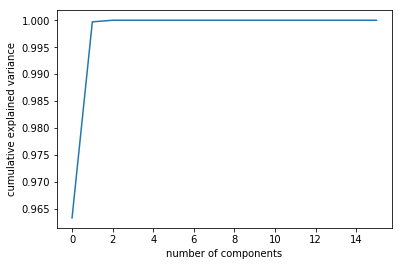

In [232]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [233]:
pca.explained_variance_ratio_

array([9.63329422e-01, 3.63725909e-02, 2.97589525e-04, 3.62268474e-07,
       3.50582806e-08, 2.85488047e-10, 8.97550980e-11, 7.49635350e-11,
       8.06476457e-13, 1.78559626e-13, 5.62102561e-14, 1.95413350e-14,
       3.15328589e-15, 1.24755366e-15, 1.61272574e-16, 8.38904969e-51])

In [234]:
pca.explained_variance_

array([9.12160129e-03, 3.44405833e-04, 2.81782423e-06, 3.43025813e-09,
       3.31960854e-10, 2.70323742e-12, 8.49875649e-13, 7.09816873e-13,
       7.63638743e-15, 1.69075052e-15, 5.32245287e-16, 1.85033554e-16,
       2.98579239e-17, 1.18128719e-17, 1.52706238e-18, 7.94344746e-53])

In [235]:
pca.singular_values_

array([2.91726824e+00, 5.66860337e-01, 5.12740676e-02, 1.78897480e-03,
       5.56524462e-04, 5.02207179e-05, 2.81590834e-05, 2.57343961e-05,
       2.66922263e-06, 1.25597382e-06, 7.04687770e-07, 4.15495254e-07,
       1.66905491e-07, 1.04982901e-07, 3.77458501e-08, 2.72235862e-25])

In [236]:
pca.n_components_

16